In [734]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

sns.set(rc={'figure.figsize':(20,7.27)})

In [378]:
#reading exists data
df = pd.read_csv('usd-tjs.csv', index_col=0)

#format date and rate of currency
df.index = pd.to_datetime(df.index)
df["Price"] = pd.to_numeric(df["Price"], downcast="float")

In [358]:
#replace zero days when NBT doesn't set rate of currency, the valeu of rate day before
for i in range(len(df['Price'])):
    if df['Price'][i] == 0:
        df['Price'][i] = df['Price'][i-1]
    else:
        continue

In [379]:
df = df[df.Price != 0]

<AxesSubplot:xlabel='Day'>

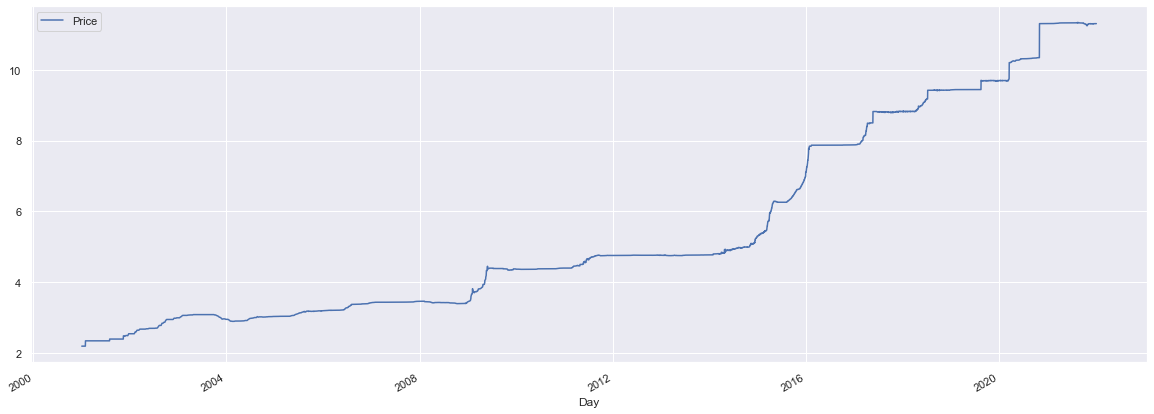

In [380]:
#function that return graph
df.plot()

In [381]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

<AxesSubplot:xlabel='year', ylabel='Price'>

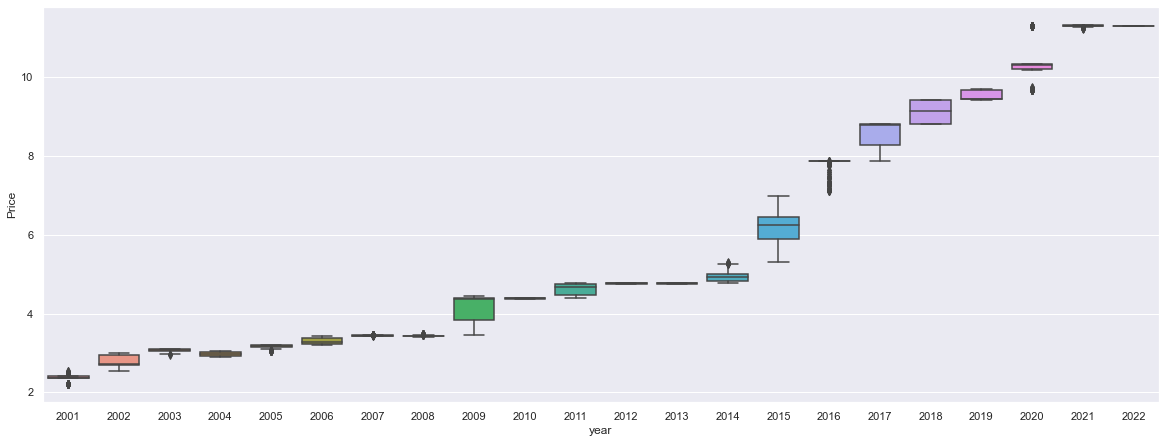

In [382]:
sns.boxplot(x='year', y='Price', data=df)

<AxesSubplot:xlabel='month', ylabel='Price'>

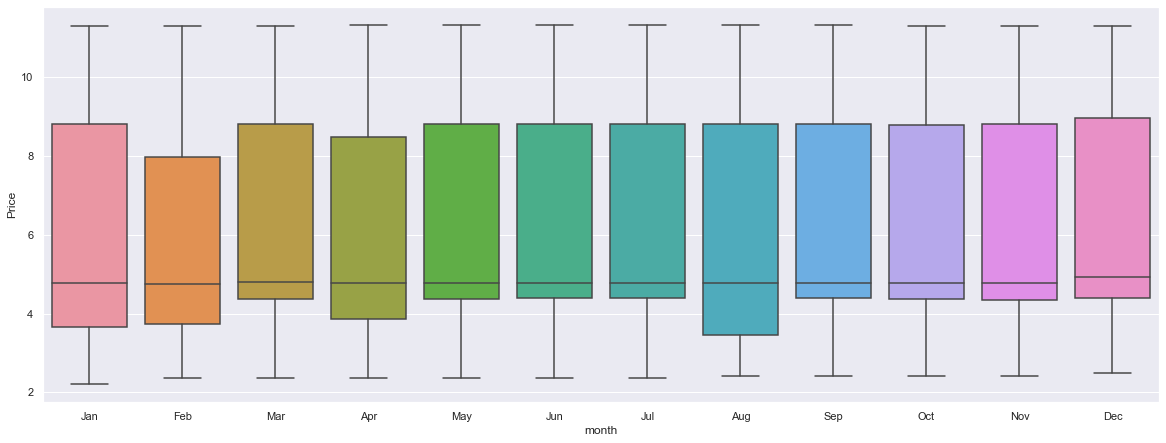

In [384]:
sns.boxplot(x='month', y='Price', data=df)

In [680]:
df_month = df.resample("MS").mean()

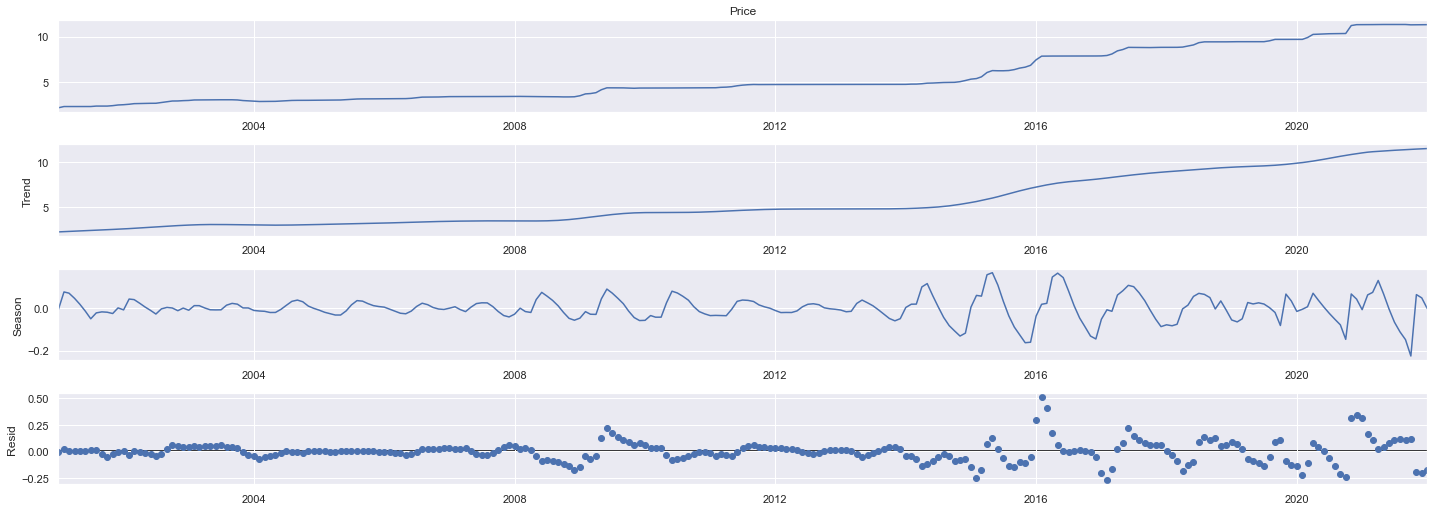

In [681]:
res = STL(df_month.Price).fit()
res.plot()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

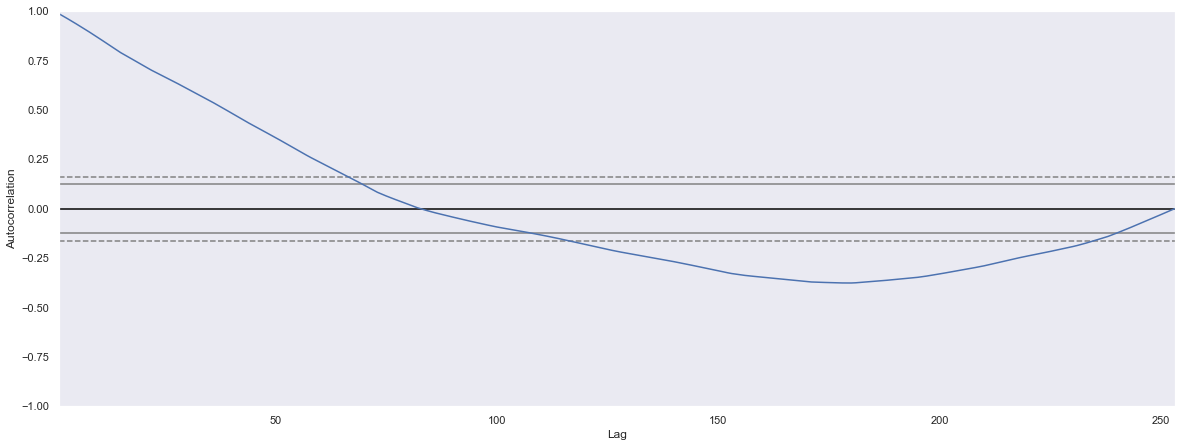

In [682]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_month.Price)

In [683]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_month.Price)

(0.9486113989691803, True)

In [684]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [685]:
adfuller_test(df_month.Price)

ADF Test Statistic : 1.469375212500037
p-value : 0.9974075995655329
#Lags Used : 1
Number of Observations Used : 251
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [686]:
# We will use auto_arima model to get best predictive model
# Of course it's not good always, auto tuning parameters and model
from pmdarima.arima import auto_arima

arima_model = auto_arima(df_month.Price, start_p=0, d=1, start_q=0,
                        max_p=5, max_q=5,max_d=5,m=12, start_P=0,D=1,start_Q=0, max_P=5, max_D=5, max_Q=5, seasonal=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-271.533, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-411.235, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-454.092, Time=0.93 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-318.600, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-453.293, Time=0.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-453.296, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-409.687, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-451.297, Time=6.36 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-454.333, Time=1.52 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-317.208, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-453.877, Time=1.32 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-453.858, Time=1.69 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-411.403, Time=0.37 sec
 ARIMA(1,1,1)(1,1,2)[12]

In [687]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  253
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 231.166
Date:                            Tue, 05 Apr 2022   AIC                           -454.333
Time:                                    01:20:08   BIC                           -440.410
Sample:                                         0   HQIC                          -448.723
                                            - 253                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2269      0.162      1.400      0.162      -0.091       0.545
ma.L1          0.2467      0.165      1.494      0.135      -0.077       0.570
ma.S.L12      -0.8716      0.058    -15.091      0.000      -0.985      -0.758
sigma2         0.0079      0.000     49.381      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             15591.69
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              28.74   Skew:                             4.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [688]:
# Split dataset into train and test datasets
size = int(len(df_month)*0.8)
X_train, X_test = df_month[0:size], df_month[size: len(df_month)]

In [689]:
# The model shows us, that SARIMAX with certain parameters is better to describe out model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX (
        X_train.Price,
        order=(1,1,1),
        seasonal_order=(0,1,1,12)
)
                
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  202
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 248.023
Date:                            Tue, 05 Apr 2022   AIC                           -488.046
Time:                                    01:20:10   BIC                           -475.079
Sample:                                01-01-2001   HQIC                          -482.792
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2994      0.070      4.259      0.000       0.162       0.437
ma.L1          0.5503      0.055      9.990      0.000       0.442       0.658
ma.S.L12      -0.7762      0.057    -13.559      0.000      -0.888      -0.664
sigma2         0.0040      0.000     23.168      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1796.51
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              10.98   Skew:                             2.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

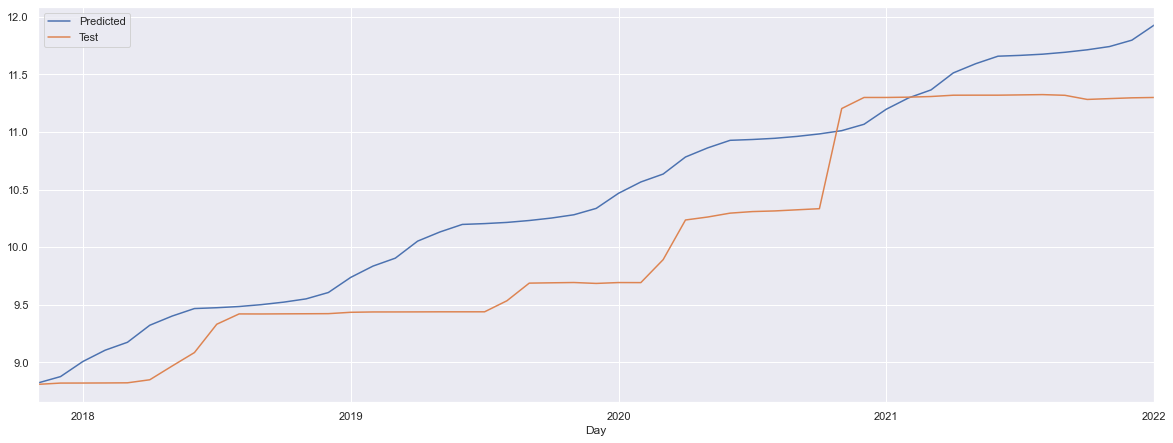

In [690]:
# checking how model predict test
start_index = len(X_train)
end_index = len(df_month)-1
prediction = result.predict(start_index, end_index).rename('Predicted')

prediction.plot(legend=True)
X_test.Price.plot(label='Test')
plt.legend()

In [691]:
print('RMSE of between predicted model and test: ', round(np.sqrt(mean_squared_error(X_test.Price, prediction)),2))
print(f'Mean: {df_month.Price.mean()} \nStandard deviation: {np.sqrt(df_month.Price.var())}')

RMSE of between predicted model and test:  0.48
Mean: 5.495157241821289 
Standard deviation: 2.754563093185425


<AxesSubplot:>

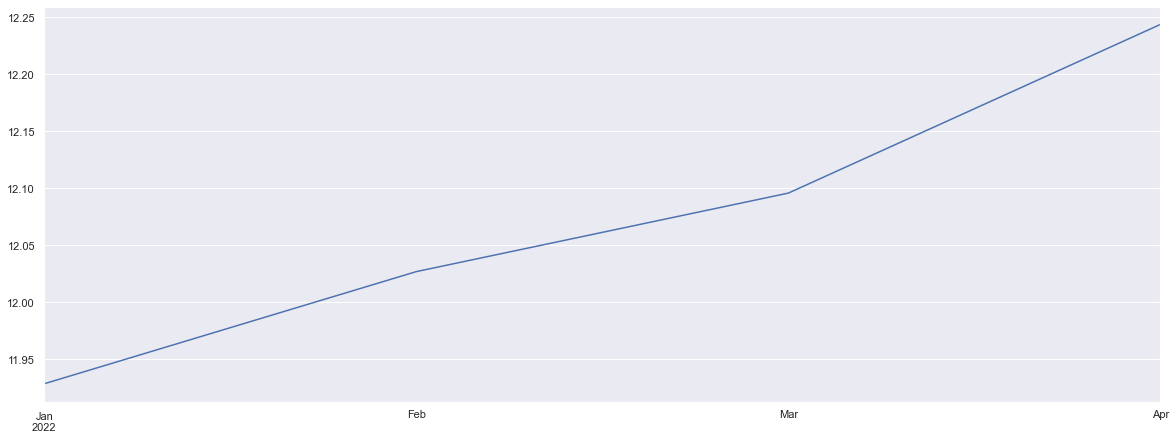

In [735]:
forecast = result.predict(start=len(df_month)-1,
                        end=(len(df_month)) + 2,
                        typ='levels'
).rename('forecast')

forecast.plot()

In [736]:
# Compare forecast of SARIMAX for next four month and actual next four month rate 
new_test = pd.read_csv('after_2022-01-01_data.csv', index_col=0)
new_test.index = pd.to_datetime(new_test.index)
new_test["Price"] = pd.to_numeric(new_test["Price"], downcast="float")

new_test_month = new_test.resample("MS").mean()

pd.DataFrame({'Price': new_test_month['Price'],'Predicted':forecast})

,Price,Predicted
2022-01-01,11.300000,11.928394
2022-02-01,11.300000,12.026690
2022-03-01,12.542581,12.095501
2022-04-01,12.615000,12.243337


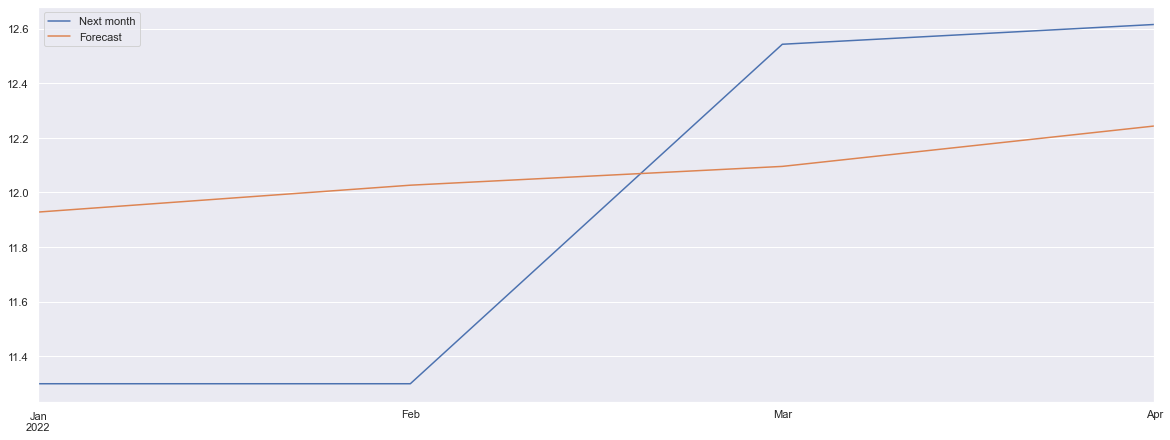

In [739]:
new_test_month.Price.plot(label='Next month')
forecast.plot(label='Forecast')
plt.legend()

In [746]:
print('RMSE of between predicted model and test: ', round(np.sqrt(mean_squared_error(new_test_month, forecast)),2))
print(f'Mean: {new_test_month.mean()} \nStandard deviation: {np.sqrt(new_test_month.var())}')

RMSE of between predicted model and test:  0.56
Mean: Price    11.939396
dtype: float32 
Standard deviation: Price    0.738901
dtype: float32


<h4>Overall</h4>
<ul>
    <li> SARIMAX is shows worse result in prediction test dataset, but much better to forecating than HW Exponential Smoothing</li>
</ul>